In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

In [9]:
warpSize = 32
# eccentricity Adams and Horton 2003 Fig.4
Ap = 9.5
Bp = 0.95
Pp = -1.03
Ae = 188
Be = 6.45
Pe = -1.85
E0 = 0.0
# traveling wave at eccentricity of 1.8 and 3.4 deg, Wilson et al 2001 Nat
max_ecc = 2 #deg 
E1 = max_ecc
vertical_slice = lambda E: 180*Ap*(E+Bp)**Pp*Be*(E+Be)**Pe # mm^2/deg
result = integrate.quad(vertical_slice,E0,E1) # mm^2
area = ((int(result[0])+warpSize-1)//warpSize) * warpSize

In [11]:
import math
## O'Kusky 1982; Kelly & Hawken 2017; M.Schmidt 2018, assuming constant density near the fovea
surface_den_L4Cbeta = 32768 # per mm^2
n_L4Cbeta = area*surface_den_L4Cbeta # 32^4 * 10 ~ 10.4 million
surface_den_L23 = 20480 # per mm^2
n_L23 = area*surface_den_L23
print(n_L4Cbeta, n_L23)

10485760 6553600


In [21]:
# for test 1/80 of final size
from macaque_fovea import *
nblock = 1024
neuron_per_block = 128
seed = 34576823
pos = construct_macaque_fovea(area_CMF, nblock, neuron_per_block, seed)
pos.tofile('1-80th_macaque_fovea_v1_3d_pos.bin')

taking up 240.0001220703125 Mb
area = 320.0 area per block = 0.03125
characteristic_length, cl = 0.176776695297
240 10000
cos(theta) of 0.9908301680442989
modulus of ring =  -0.29839367086
corrected cl =  0.177763475433 nring = 82
avg iterations = 5.951219512195122
avg biterations = 10.890243902439025
10000 blocks constructed
upper estimate 26 stripes
#21 limited to 6.999999999999048
21 120.0 240


AssertionError: 

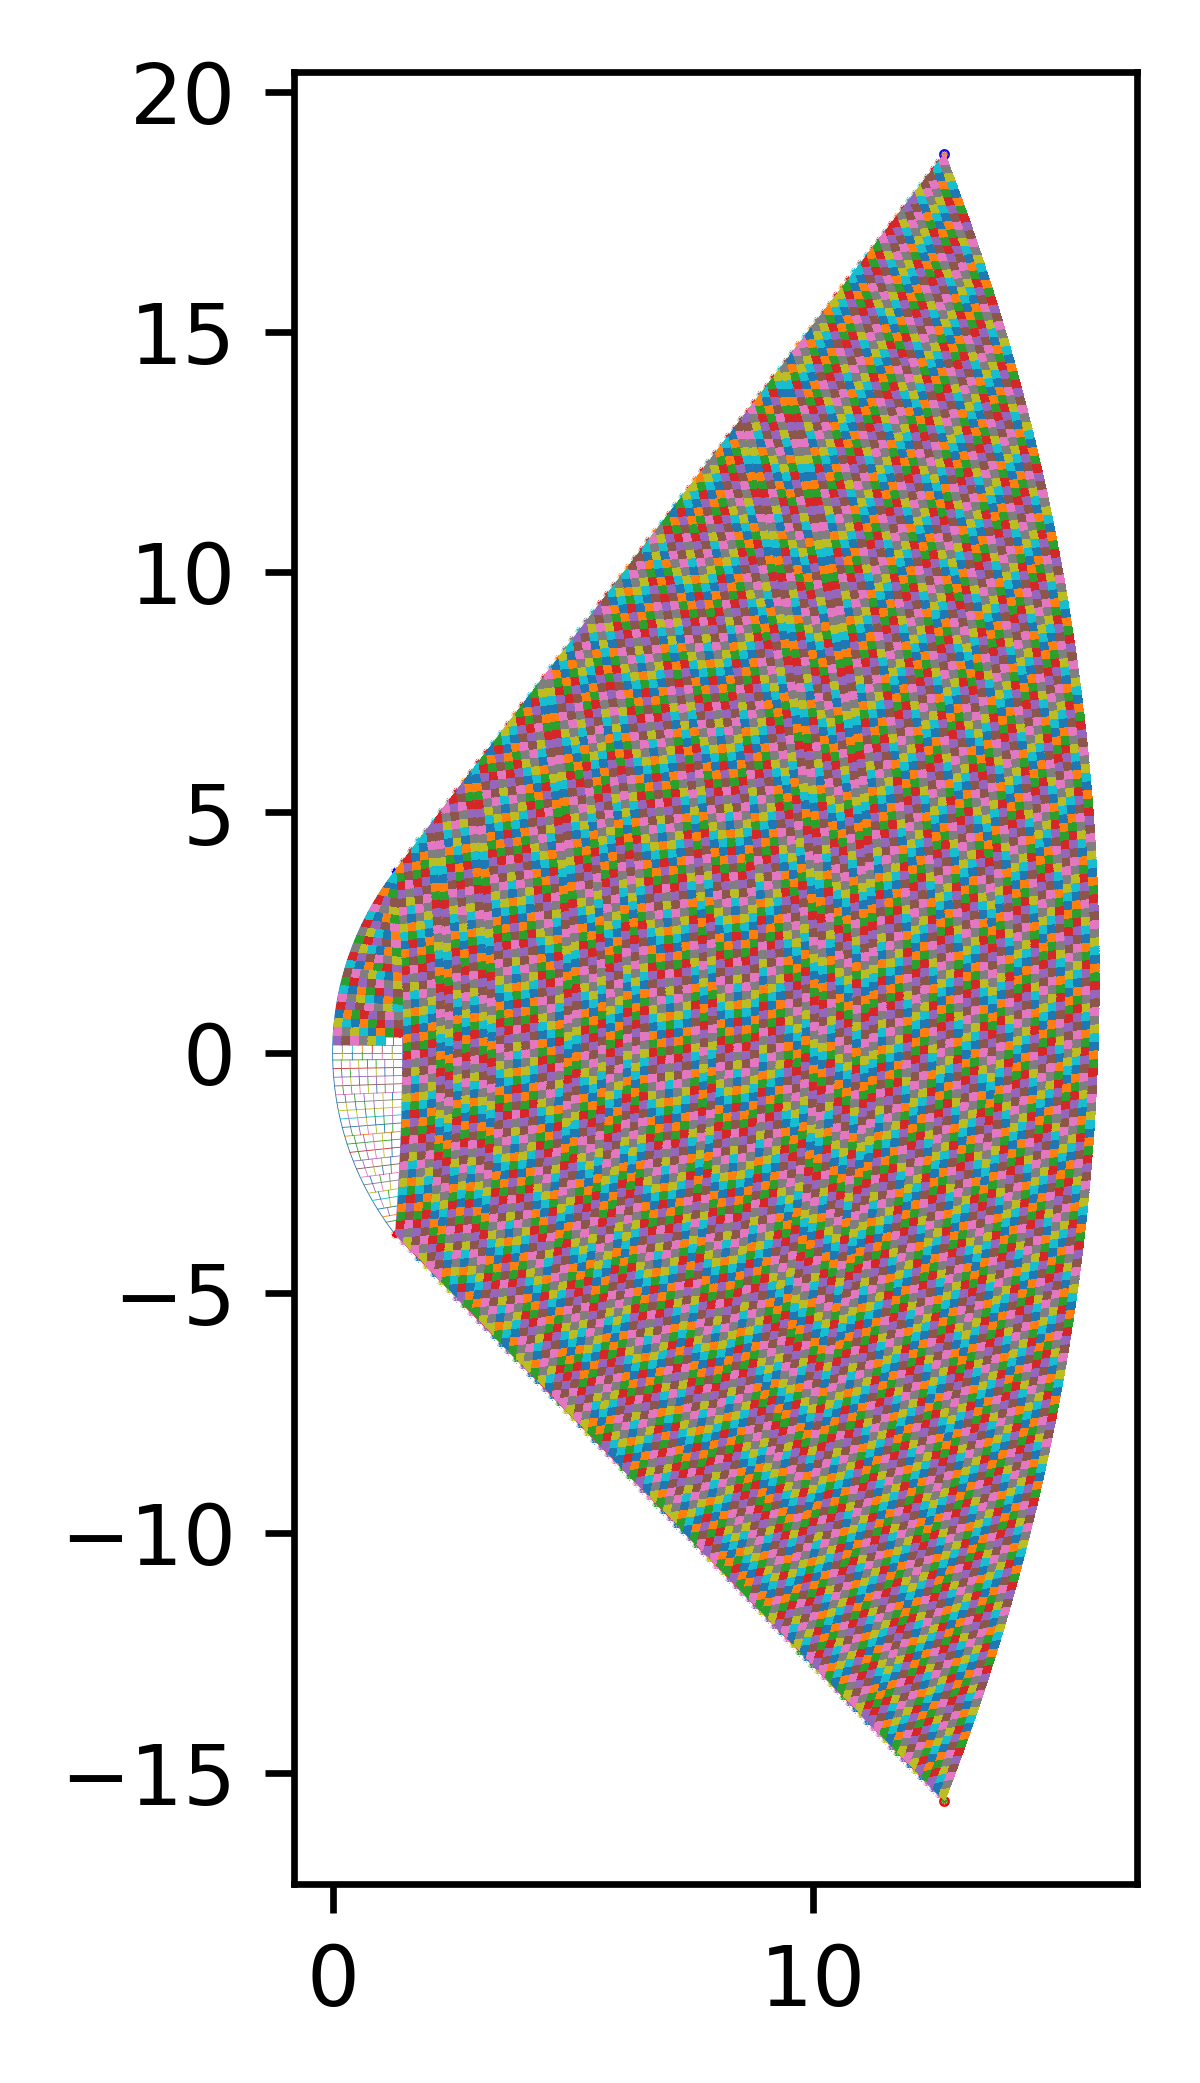

In [24]:
nblock = 10240
neuron_per_block = 1024
seed = 34576823
pos = construct_macaque_fovea(area_CMF, nblock, neuron_per_block, seed)
pos.tofile('full_macaque_fovea_v1_3d_pos.bin')

In [23]:
fig.savefig('shape.png', dpi = 600)

characteristic length =

In [20]:
cl = np.sqrt(area_CMF/10240) * 1000
print(cl)

176.7766952966369


~177x177x100 $\mu m^3$ (1024 neurons) per block, average inter-neuron(soma)-distance =

In [22]:
md = np.power(cl*cl*100/1024,1/3)
print(md)

14.504965105039933


conduction velocity ~ 1m/s, being unmylineated horizontal connections  
(0.3m/s for L2/3 and upper L4) <i>Girard et al J Neurophysiol 2001</i>  
minmum delay = 0.0145ms, no spike-correction is needed for time step (dt) < minimum delay
100Hz instantaneous firing rate, 1000 connections leads to ~ 100 spikes per time step, an effective dt of 0.01ms regardless of preset dt

In [24]:
nob = 1000/cl
print(nob)

5.65685424949238


dt = 1ms means neurons in the nearest 5~6 blocks needs to be considered for spike correction  
dt = 0.125ms (1/8) suffice for spike correction within block, #ASSUMPTION# nearfield spike correction only (neurons at block boundarys are neglected) spikes send to the other blocks are resolved after the current step.

#dt = 0.125ms is thus limited by the number of threads per block in NVIDIA GPU  
To further increase dt, will need a cross block spike-correction with CPU, or wait for an update from NVIDIA, otherwise results in an extra increase in spike-correction error, maybe tolerable.

In [102]:
time = 0.5
dt = 0.0125e-3
batch_time_per_dt = 500e-6 #sec
nstep = time//dt
blocks = 10240
resident_blocks = 8
time_cost = np.int(blocks/resident_blocks) * batch_time_per_dt * nstep
print('simulate for', time ,'ms with dt =',dt, 'cost', time_cost/3600,'h')

simulate for 0.5 ms with dt = 1.25e-05 cost 7.1109333333333336 h
